# The Famous Home Run Duel Between Mark McGwire and Sammy Sosa in 1998

### *Data*
We use baseball data from [Lahman Basebaball Database](http://www.seanlahman.com/) and [Retrosheet](https://www.retrosheet.org/). 
- Just to reproduce what's in the code, I included the CSV files in the repo already. If you're interested in getting all the data in Lahman Database or Retrosheet, please refer to the following 2 bullet points. 
- Download CSV files from [Lahman Baseball Database](https://www.dropbox.com/scl/fi/hy0sxw6gaai7ghemrshi8/lahman_1871-2023_csv.7z?rlkey=edw1u63zzxg48gvpcmr3qpnhz&e=1&dl=0). I have them stored under `data` folder in the same directory as this notebook. If you store them somewhere else, make sure to change the file path in the code.
- Download retrosheet data in CSV files. This process can be a bit tricky. I followed [this process](https://github.com/davidbmitchell/Baseball-PostgreSQL) to download the CSV files. If you're on mac, I created a shell script you may use for downloading the retrosheet data. Note that you'll need to change the file/folder path in the script. 
### *Packages*
- We use polars and plotnine in this notebook. Make sure to download them via your package manager. 
### *Description of the viz*
- We recreate the viz found in [Chapter 3: Graphics - Analyzing Baseball Data with R (3e)](https://beanumber.github.io/abdwr3e/03-graphics2.html), displaying the cumulative sum of home runs among a few top players in 1998 season. 
- We also add another player in the viz for the home run race.

### *References*
- Section ` 3.8 The 1998 Home Run Race` in [Chapter 3: Graphics - Analyzing Baseball Data with R (3e)](https://beanumber.github.io/abdwr3e/03-graphics2.html)


## 0. Import libraries

In [14]:
import polars as pl
from plotnine import *

## 1. Get player ids from lahman database

In [15]:
people = pl.scan_csv('data/lahman/lahman_1871-2023/People.csv',  encoding='utf8-lossy', try_parse_dates=True)

In [16]:
sosa_player_id = (
    people
    .filter(nameFirst='Sammy', nameLast='Sosa')
    .select('retroID')
    .collect().item()
)

mcgwire_player_id = (
    people
    .filter(nameFirst='Mark', nameLast='McGwire')
    .select('retroID')
    .collect().item()
)

sosa_player_id, mcgwire_player_id

('sosas001', 'mcgwm001')

## 2. Create the dataframe from retrosheet play by play data

Filtering down the data to only show play by play data for Sosa and McGwire

In [17]:
season = 1998

retro_1998_sosa_mcgwire = (
    pl.scan_csv(f'data/retrosheet/parsed/all{season}.csv', try_parse_dates=True, schema_overrides={'AWAY_LINE_TX': pl.Utf8})
    .filter(
        (pl.col('BAT_ID') == sosa_player_id)
        | (pl.col('BAT_ID') == mcgwire_player_id)
    )
)

In [18]:
retro_1998_sosa_mcgwire.head().collect()

GAME_ID,AWAY_TEAM_ID,INN_CT,BAT_HOME_ID,OUTS_CT,BALLS_CT,STRIKES_CT,PITCH_SEQ_TX,AWAY_SCORE_CT,HOME_SCORE_CT,BAT_ID,BAT_HAND_CD,RESP_BAT_ID,RESP_BAT_HAND_CD,PIT_ID,PIT_HAND_CD,RESP_PIT_ID,RESP_PIT_HAND_CD,POS2_FLD_ID,POS3_FLD_ID,POS4_FLD_ID,POS5_FLD_ID,POS6_FLD_ID,POS7_FLD_ID,POS8_FLD_ID,POS9_FLD_ID,BASE1_RUN_ID,BASE2_RUN_ID,BASE3_RUN_ID,EVENT_TX,LEADOFF_FL,PH_FL,BAT_FLD_CD,BAT_LINEUP_ID,EVENT_CD,BAT_EVENT_FL,AB_FL,…,RUN2_FLD_CD,RUN2_LINEUP_CD,RUN2_ORIGIN_EVENT_ID,RUN3_FLD_CD,RUN3_LINEUP_CD,RUN3_ORIGIN_EVENT_ID,RUN1_RESP_CAT_ID,RUN2_RESP_CAT_ID,RUN3_RESP_CAT_ID,PA_BALL_CT,PA_CALLED_BALL_CT,PA_INTENT_BALL_CT,PA_PITCHOUT_BALL_CT,PA_HITBATTER_BALL_CT,PA_OTHER_BALL_CT,PA_STRIKE_CT,PA_CALLED_STRIKE_CT,PA_SWINGMISS_STRIKE_CT,PA_FOUL_STRIKE_CT,PA_INPLAY_STRIKE_CT,PA_OTHER_STRIKE_CT,EVENT_RUNS_CT,FLD_ID,BASE2_FORCE_FL,BASE3_FORCE_FL,BASE4_FORCE_FL,BAT_SAFE_ERR_FL,BAT_FATE_ID,RUN1_FATE_ID,RUN2_FATE_ID,RUN3_FATE_ID,FATE_RUNS_CT,ASS6_FLD_CD,ASS7_FLD_CD,ASS8_FLD_CD,ASS9_FLD_CD,ASS10_FLD_CD
str,str,i64,i64,i64,i64,i64,str,i64,i64,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,i64,i64,i64,str,str,…,i64,i64,i64,i64,i64,i64,str,str,str,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,str,str,str,str,str,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64
"""ARI199805110""","""CHN""",1,0,2,2,1,"""SBBX""",1,0,"""sosas001""","""R""","""sosas001""","""R""","""andeb002""","""L""","""andeb002""","""L""","""fabrj001""","""lee-t002""","""batit001""","""fox-a001""","""bellj001""","""delld001""","""whitd001""","""bredb001""","""""","""""","""""","""9/P9LS""","""F""","""F""",9,4,2,"""T""","""T""",…,0,0,0,0,0,0,"""""","""""","""""",2,2,0,0,0,0,2,0,1,0,1,0,0,"""bredb001""","""F""","""F""","""F""","""F""",0,0,0,0,0,0,0,0,0,0
"""ARI199805110""","""CHN""",4,0,0,1,2,"""CSBFX""",3,0,"""sosas001""","""R""","""sosas001""","""R""","""andeb002""","""L""","""andeb002""","""L""","""fabrj001""","""lee-t002""","""batit001""","""fox-a001""","""bellj001""","""delld001""","""whitd001""","""bredb001""","""""","""""","""""","""3/G3""","""T""","""F""",9,4,2,"""T""","""T""",…,0,0,0,0,0,0,"""""","""""","""""",1,1,0,0,0,0,4,1,1,1,1,0,0,"""lee-t002""","""F""","""F""","""F""","""F""",0,0,0,0,0,0,0,0,0,0
"""ARI199805110""","""CHN""",6,0,2,3,0,"""IIII""",3,0,"""sosas001""","""R""","""sosas001""","""R""","""andeb002""","""L""","""andeb002""","""L""","""stink001""","""lee-t002""","""batit001""","""fox-a001""","""bellj001""","""delld001""","""whitd001""","""bredb001""","""""","""miesm001""","""""","""IW""","""F""","""F""",9,4,15,"""T""","""F""",…,7,2,38,0,0,0,"""""","""stink001""","""""",4,0,4,0,0,0,0,0,0,0,0,0,0,"""""","""F""","""F""","""F""","""F""",0,0,0,0,0,0,0,0,0,0
"""ARI199805110""","""CHN""",8,0,0,1,2,"""FFFBX""",4,1,"""sosas001""","""R""","""sosas001""","""R""","""sodoc001""","""R""","""sodoc001""","""R""","""stink001""","""lee-t002""","""batit001""","""fox-a001""","""bellj001""","""delld001""","""whitd001""","""bredb001""","""""","""""","""""","""S6/G""","""T""","""F""",9,4,20,"""T""","""T""",…,0,0,0,0,0,0,"""""","""""","""""",1,1,0,0,0,0,4,0,0,3,1,0,0,"""bellj001""","""F""","""F""","""F""","""F""",0,0,0,0,0,0,0,0,0,0
"""ARI199805120""","""CHN""",1,0,2,3,2,"""CBBSBX""",0,0,"""sosas001""","""R""","""sosas001""","""R""","""benea001""","""R""","""benea001""","""R""","""stink001""","""lee-t002""","""stana001""","""batit001""","""bellj001""","""beniy001""","""whitd001""","""meulh001""","""""","""""","""""","""53/G3D""","""F""","""F""",9,3,2,"""T""","""T""",…,0,0,0,0,0,0,"""""","""""","""""",3,3,0,0,0,0,3,1,1,0,1,0,0,"""batit001""","""F""","""F""","""F""","""F""",0,0,0,0,0,0,0,0,0,0


Transform the data

In [19]:
hr_race_1998 = (
    retro_1998_sosa_mcgwire
    .filter(EVENT_CD=23)
    .select(
        pl.col('GAME_ID').str.slice(3, 8).str.to_date('%Y%m%d').alias('DATE'),
        'BAT_ID',
        pl.lit(1).alias('HR')
    )
    .group_by('DATE', 'BAT_ID')
    .agg(pl.col('HR').sum())
    .sort('BAT_ID', 'DATE')
    .with_columns(
        pl.col('HR').cum_sum().over('BAT_ID')
    )
    .join(
        people,
        left_on='BAT_ID',
        right_on='retroID',
        how='left'
    )
    .select(
        (pl.col('nameFirst') + ' ' + pl.col('nameLast')).alias('NAME'),
        'DATE',
        'HR'
    )
    .collect()
)

## 4. Create a graphic showing the home run race

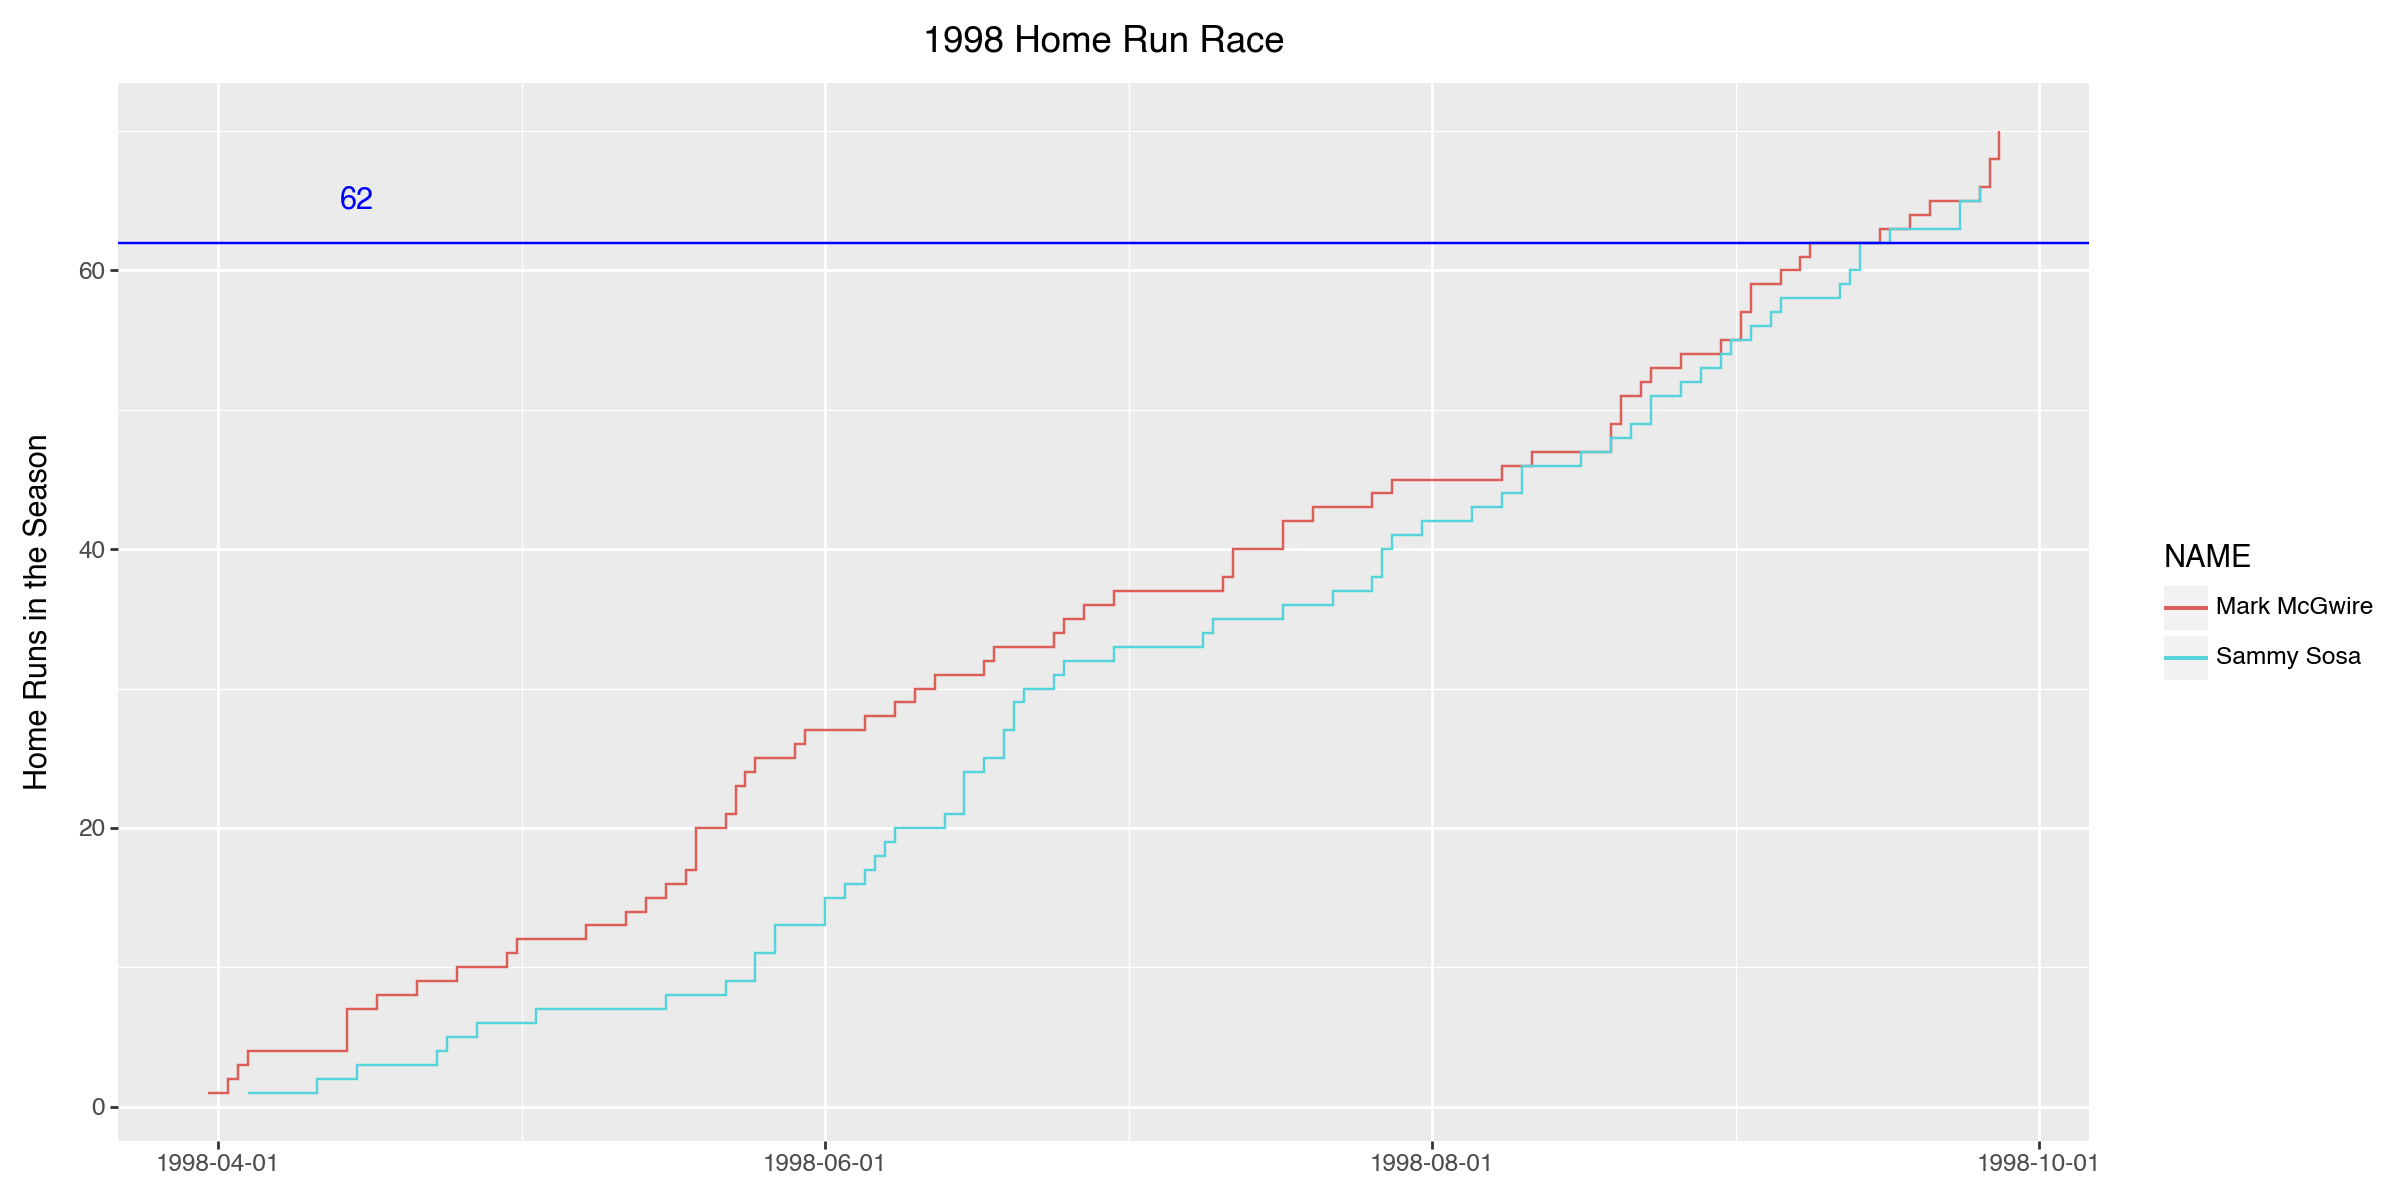

In [23]:
(
    ggplot(data=hr_race_1998, mapping=aes(x='DATE', y='HR', color='NAME'))
    + geom_step()
    + geom_hline(yintercept=62, color='blue')
    + annotate('text', '1998-04-15', 65, label='62', color='blue')
    + labs(title='1998 Home Run Race', x='', y='Home Runs in the Season')
    + theme(figure_size=(12, 6)) 
)

## (Optional) 5. Make it so that we can compare other players as well

Just defining functions

In [24]:
def get_retro_id(first_name, last_name):
    player_id = (
        people
        .filter(nameFirst=first_name, nameLast=last_name)
        .select('retroID')
        .collect().item()
    )
    return player_id

def get_retro_play_by_play_data(season, retro_ids):
    retrosheet_data = (
        pl.scan_csv(f'data/retrosheet/parsed/all{season}.csv', try_parse_dates=True, schema_overrides={'AWAY_LINE_TX': pl.Utf8})
        .filter(
            (pl.col('BAT_ID').is_in(retro_ids))
        )
    )
    return retrosheet_data

def get_df_hr_by_date_and_player(data):
    df = (
        data
        .filter(EVENT_CD=23)
        .select(
            pl.col('GAME_ID').str.slice(3, 8).str.to_date('%Y%m%d').alias('DATE'),
            'BAT_ID',
            pl.lit(1).alias('HR')
        )
        .group_by('DATE', 'BAT_ID')
        .agg(pl.col('HR').sum())
        .sort('BAT_ID', 'DATE')
        .with_columns(
            pl.col('HR').cum_sum().over('BAT_ID')
        )
        .join(
            people,
            left_on='BAT_ID',
            right_on='retroID',
            how='left'
        )
        .select(
            (pl.col('nameFirst') + ' ' + pl.col('nameLast')).alias('NAME'),
            'DATE',
            'HR'
        )
        .collect()
    )
    return df

def visualize_df_hr_by_date_and_player(df):
    year = df.select(pl.col('DATE').dt.year())[0,0]
    viz = (
        ggplot(data=df, mapping=aes(x='DATE', y='HR', color='NAME'))
        + geom_step()
        + geom_hline(yintercept=62, color='blue')
        + annotate('text', f'{year}-04-15', 65, label='62', color='blue')
        + labs(title=f'{year} Home Run Race', x='', y='Home Runs in the Season')
        + theme(figure_size=(12, 6)) 
    )
    return viz

## (Optional) 6. Add Ken Griffey Jr in the race

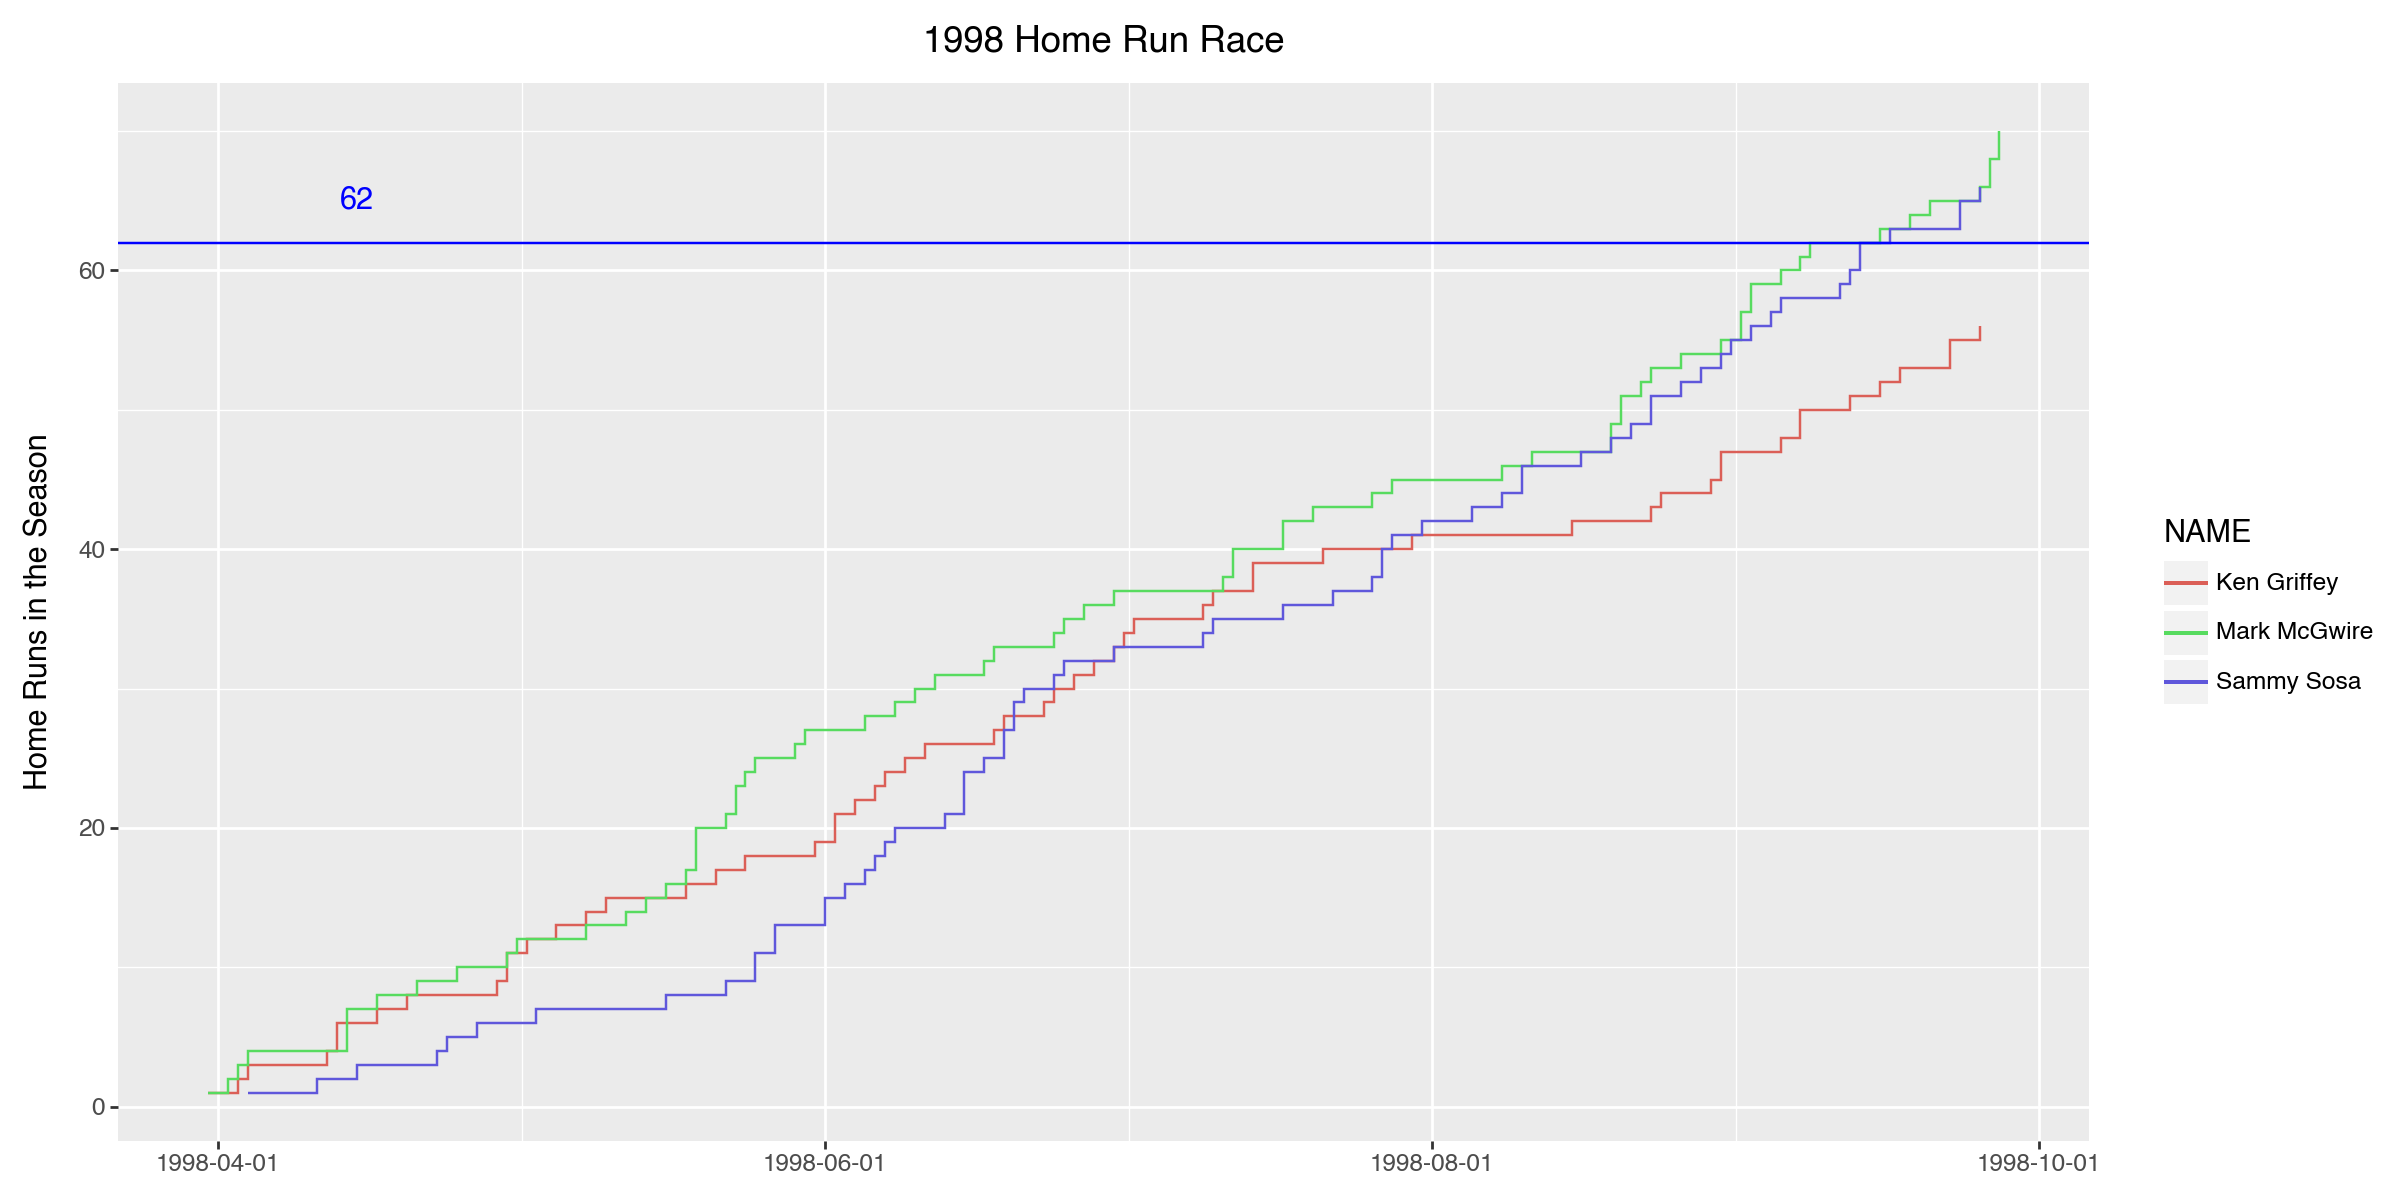

In [25]:
sosa = get_retro_id(first_name='Sammy', last_name='Sosa')
mcg = get_retro_id(first_name='Mark', last_name='McGwire')
gri = 'grifk002' # get_retro_id(first_name='Ken', last_name='Griffey')  # this gets you the id of his father, which is grif001

retro_data = get_retro_play_by_play_data(season=1998, retro_ids=[sosa, mcg, gri])
df = get_df_hr_by_date_and_player(retro_data)
visualize_df_hr_by_date_and_player(df)